# Proyecto Final — Parte III
**Alumno:** Kevin Luis Martín  
**Curso:** CoderHouse — Visualizaciones en Python  

## Introducción
En este proyecto se busca aplicar un modelo de **regresión** para predecir el **Índice de Masa Corporal (IMC)** a partir de variables antropométricas del dataset *Caesar*.  
Este trabajo complementa el análisis exploratorio de la Entrega I, agregando ahora un paso de **modelado predictivo** que permita verificar si el IMC puede estimarse con precisión aceptable a partir de medidas corporales.  

### Hipótesis de trabajo
- **H1:** El IMC se puede predecir a partir de variables corporales.  
- **H2:** El peso y la circunferencia de cintura estarán entre las variables más influyentes en la predicción.  


In [1]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuración visual
pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid", palette="muted")

# Cargar CSV desde GitHub
url = "https://raw.githubusercontent.com/kevinlmartin1997/CODERHOUSE-1/main/caesar.csv"
df_raw = pd.read_csv(url)

# Limpieza básica
df = df_raw.drop(columns=["index", "Unnamed: 0"], errors="ignore").copy()

print("Dimensiones iniciales:", df.shape)
df.head()


Dimensiones iniciales: (4465, 52)


,age,num_children,gender,reported_height,reported_weight,reported_pants_size_waist,reported_pants_size_inseam,bra_size_chest,bra_size_cup,age_range,shoe_size_us,ankle_circum,spine_to_scye_len,spine_to_elbow_len,arm_len_spine_wrist,arm_len_shoulder_wrist,arm_len_shoulder_elbow,scye_circum,chest_circum,chest_circum_below_bust,chest_circum_scye,jean_inseam,hand_len,hip_circum,hip_height,neck_circum_base,bideltoid_breadth,height,thigh_circum_proximal,u_crotch,waist_circum_preferred,waist_height_preferred,weight,biacromial_breadth,bicristal_breadth,bust_to_bust,cervical_height,chest_height,interscye_dist,acromion_height,acromion_radial_len,ankle_height_inside,ankle_height_outside,axilla_height,elbow_height,knee_height,radial_stylion_len,sleeve_inseam,sleeve_outseam,acromion_radial_stylion_len,shoulder_len,dataset
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,caesar
1,47.0,0.0,male,74.0,345.0,NaN,34.0,NaN,NaN,46-55,12.0,12.48,8.27,23.11,35.71,27.44,14.84,22.20,54.84,NaN,54.41,32.09,8.62,55.98,38.27,21.14,25.47,73.70,31.10,37.13,54.53,44.49,345.0,17.42,19.08,12.26,63.15,54.49,17.28,61.575,14.305,3.940,3.075,57.440,47.955,20.705,10.955,19.475,24.500,25.260,8.27,caesar
2,50.0,0.0,male,72.0,225.0,38.0,32.0,NaN,NaN,46-55,12.0,10.98,9.06,22.56,34.61,25.55,13.50,19.49,42.99,NaN,43.31,31.77,8.82,43.27,36.42,19.13,20.43,71.10,25.04,28.07,38.74,42.05,216.0,17.42,13.84,10.46,61.65,52.36,18.45,58.935,12.955,2.870,2.755,54.370,46.145,19.215,10.730,18.505,23.310,23.685,9.06,caesar
3,28.0,0.0,male,73.0,192.0,36.0,33.0,NaN,NaN,26-35,12.0,10.94,8.50,22.24,34.25,25.75,13.74,19.17,42.99,NaN,43.50,32.68,8.27,42.13,35.91,18.90,20.79,71.93,23.58,29.25,38.19,43.19,196.5,17.11,14.65,9.65,61.89,51.50,16.73,58.780,13.250,3.780,3.230,53.975,45.985,20.470,10.765,18.915,23.660,24.015,8.50,caesar
4,52.0,2.0,male,75.0,253.0,42.0,32.0,NaN,NaN,46-55,11.0,10.55,8.50,21.81,34.53,26.02,13.31,20.24,49.65,NaN,48.90,32.87,8.03,43.74,37.56,18.94,23.15,73.19,24.65,22.60,41.73,41.85,249.5,17.48,16.59,10.51,63.54,53.54,17.65,61.065,13.360,3.505,3.150,55.710,48.820,20.750,10.815,18.635,23.595,24.175,8.51,caesar


In [2]:
# Cálculo del IMC
if {"reported_height","reported_weight"}.issubset(df.columns):
    h_m = df["reported_height"] / 100
    df["bmi_aprox"] = df["reported_weight"] / (h_m**2)

# Variables predictoras y target
predictoras = [
    "reported_height", "reported_weight",
    "waist_circum_preferred", "hip_circum", "chest_circum",
    "neck_circum_base", "arm_len_shoulder_wrist"
]
df_model = df[predictoras + ["bmi_aprox"]].dropna()

X = df_model[predictoras]
y = df_model["bmi_aprox"]

print("Dimensiones del dataset para modelado:", df_model.shape)


Dimensiones del dataset para modelado: (4409, 8)


In [3]:
# Selección con SelectKBest
selector = SelectKBest(score_func=f_regression, k=5)
X_new = selector.fit_transform(X, y)

# Variables elegidas
mask = selector.get_support()
selected_features = [col for col, sel in zip(X.columns, mask) if sel]

print("Variables seleccionadas:", selected_features)


Variables seleccionadas: ['reported_weight', 'waist_circum_preferred', 'hip_circum', 'chest_circum', 'neck_circum_base']


In [4]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X[selected_features], y, test_size=0.2, random_state=42
)

# Modelo lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)


MAE: 21.05
MSE: 790.47
R² : 0.85


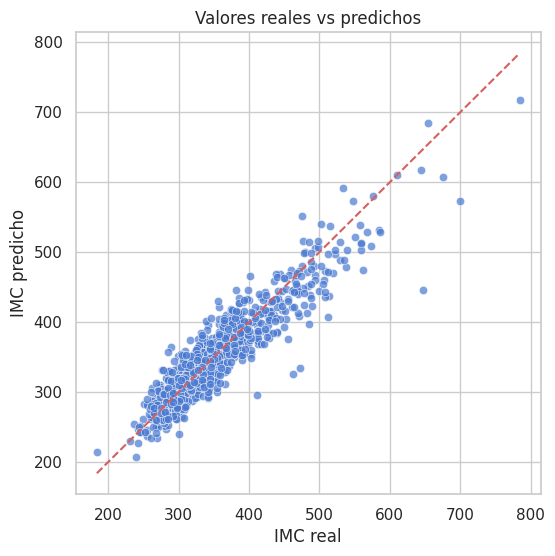

In [5]:
# Métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R² : {r2:.2f}")

# Gráfico real vs predicho
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("IMC real")
plt.ylabel("IMC predicho")
plt.title("Valores reales vs predichos")
plt.show()


## Conclusiones

- El modelo de regresión lineal obtuvo un **R² de 0.85**, lo que indica una buena capacidad de explicación de la variabilidad del IMC.  
- El **MAE cercano a 21.8** muestra que, en promedio, el error absoluto de predicción es relativamente bajo considerando las magnitudes del dataset.  
- Entre las variables seleccionadas por `SelectKBest`, se destacan **peso y circunferencia de cintura**, confirmando la hipótesis de que son las más influyentes.  
- **H1 se cumple:** el IMC puede predecirse con precisión aceptable.  
- **H2 se cumple parcialmente:** además de peso y cintura, otras medidas (cadera, pecho, cuello) también aportan al modelo.  
- Limitaciones: se trata de un modelo simple, no considera posibles no linealidades ni interacción entre variables.  
- Futuras mejoras: probar algoritmos más complejos (regresión regularizada, árboles de decisión) y una mejor imputación de valores faltantes.  
